In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
import splitfolders
import shutil
import random


main_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
dataset_dir = os.path.join(main_dir, 'image_dataset')
dataset_dir_2 = os.path.join(main_dir, 'image_dataset_2')
train_dir = os.path.join(dataset_dir_2, 'train')
val_dir = os.path.join(dataset_dir_2, 'val')
test_dir = os.path.join(dataset_dir_2, 'test')
print(main_dir)
print(dataset_dir)
print(dataset_dir_2)
print(train_dir)
print(val_dir)
print(test_dir)


def split_images():
    randNum = random.randint(0, 1337)
    if os.path.exists(dataset_dir_2):
        shutil.rmtree(dataset_dir_2)
    if not os.path.exists(dataset_dir_2):
        os.mkdir(dataset_dir_2)
    splitfolders.ratio(dataset_dir, output=dataset_dir_2, 
                       seed=randNum, ratio=(.7, .1, .2), 
                       group_prefix=None)
    return "Dataset splitting completed"
    

C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML
C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\image_dataset
C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\image_dataset_2
C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\image_dataset_2\train
C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\image_dataset_2\val
C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\image_dataset_2\test


In [2]:
#Splits the dataset
split_images()

Copying files: 291 files [00:00, 725.69 files/s]


'Dataset splitting completed'

In [25]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                           batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           batch_size=60,
                                                          image_size=IMG_SIZE)

Found 203 files belonging to 2 classes.
Found 28 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


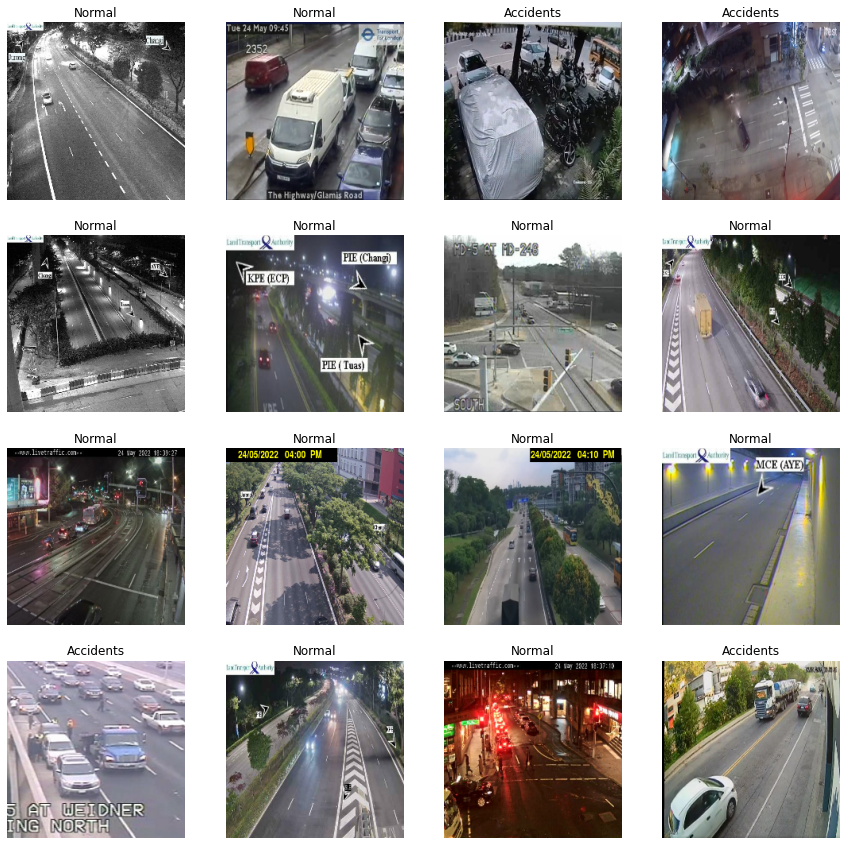

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the Dataset For Performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

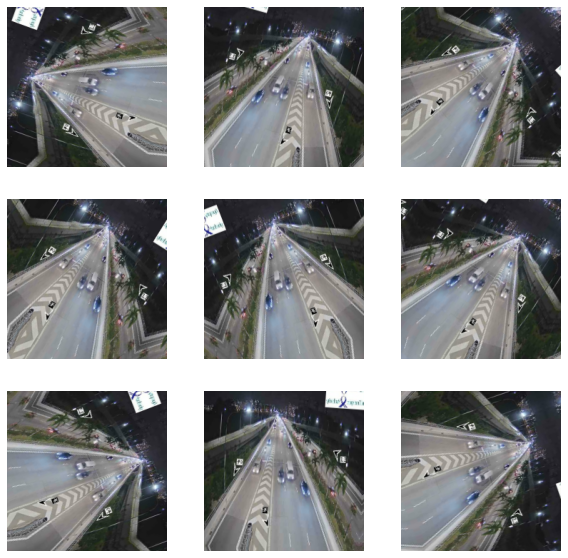

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescaling Pixel Values

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Creating Base Model from MobileNet V2

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 1280)


In [9]:
### Freeze The Convolutional Base
#It is important to freeze the convolutional base before you compile and train the model. 
#Freezing (by setting layer.trainable = False) prevents the weights in a given layer from 
#being updated during training. MobileNet V2 has many layers, so setting the entire model's 
#trainable flag to False will freeze all of them.

base_model.trainable = False

In [10]:
### Important note about BatchNormalization layers

#Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions 
#should be taken in the context of fine-tuning, as shown later in this tutorial. 

#When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will 
#not update its mean and variance statistics. 

#When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep 
#the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. 
#Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

#For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [11]:
### Add a classification head

#To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
# Keras Dense layer is added to convert features into a single predictions per image, 
# in which positive numbers predict class 1 (Normal Roads) and negative numbers predict
# no activation is required as predictions will be a logit or raw prediction value

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [13]:
#Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor 
#layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, 
#use `training=False` as our model contains a `BatchNormalization` layer.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
### Compile the model

#Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` 
#loss with `from_logits=True` since the model provides a linear output.

base_learning_rate = 0.00012
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

#The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. 
#These are divided between two `tf.Variable` objects, the weights and biases.

len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

2

In [15]:
### Train the model

#After training for 10 epochs, you should see ~94% accuracy on the validation set.

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

initial_epochs = 50

start_time = time.time()


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks =[earlystopping])



Epoch 1/50
7/7 [==============================] - 9s 716ms/step - loss: 0.7480 - accuracy: 0.4975 - val_loss: 0.6148 - val_accuracy: 0.6071
Epoch 2/50
7/7 [==============================] - 4s 559ms/step - loss: 0.7478 - accuracy: 0.5419 - val_loss: 0.5926 - val_accuracy: 0.6429
Epoch 3/50
7/7 [==============================] - 4s 555ms/step - loss: 0.6588 - accuracy: 0.6010 - val_loss: 0.5787 - val_accuracy: 0.6786
Epoch 4/50
7/7 [==============================] - 4s 528ms/step - loss: 0.7248 - accuracy: 0.5665 - val_loss: 0.5652 - val_accuracy: 0.6786
Epoch 5/50
7/7 [==============================] - 4s 531ms/step - loss: 0.6737 - accuracy: 0.6059 - val_loss: 0.5523 - val_accuracy: 0.6786
Epoch 6/50
7/7 [==============================] - 4s 528ms/step - loss: 0.6590 - accuracy: 0.5961 - val_loss: 0.5399 - val_accuracy: 0.6786
Epoch 7/50
7/7 [==============================] - 4s 545ms/step - loss: 0.6208 - accuracy: 0.6207 - val_loss: 0.5280 - val_accuracy: 0.7143
Epoch 8/50
7/7 [====

# Fine tuning

In [16]:
#In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. 
#The weights of the pre-trained network were **not** updated during training.

#One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the 
#pre-trained model alongside the training of the classifier you added. The training process will force the weights 
#to be tuned from generic feature maps to features associated specifically with the dataset.

#Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set 
#to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train 
#all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) 
#and your pre-trained model will forget what it has learned.

#Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional 
#networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features 
#that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset 
#on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, 
#rather than overwrite the generic learning.

### Un-freeze the top layers of the model


#All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the 
#model (necessary for these changes to take effect), and resume training.

base_model.trainable = True

In [17]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [18]:
### Compile the model

#As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower 
#learning rate at this stage. Otherwise, your model could overfit very quickly.
ft_learning_rate = 0.000008

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=ft_learning_rate),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

154

In [19]:
### Continue training the model

#If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=(history.epoch[-1]+1),
                         validation_data=validation_dataset,
                         callbacks =[earlystopping])



Epoch 51/100
7/7 [==============================] - 22s 2s/step - loss: 0.3489 - accuracy: 0.8374 - val_loss: 0.2636 - val_accuracy: 0.8571
Epoch 52/100
7/7 [==============================] - 12s 2s/step - loss: 0.3160 - accuracy: 0.8522 - val_loss: 0.2524 - val_accuracy: 0.8571
Epoch 53/100
7/7 [==============================] - 12s 2s/step - loss: 0.2523 - accuracy: 0.8966 - val_loss: 0.2311 - val_accuracy: 0.8929
Epoch 54/100
7/7 [==============================] - 13s 2s/step - loss: 0.2549 - accuracy: 0.9015 - val_loss: 0.2243 - val_accuracy: 0.8571
Epoch 55/100
7/7 [==============================] - 12s 2s/step - loss: 0.2244 - accuracy: 0.9261 - val_loss: 0.2086 - val_accuracy: 0.8929
Epoch 56/100
7/7 [==============================] - 12s 2s/step - loss: 0.1981 - accuracy: 0.9113 - val_loss: 0.2143 - val_accuracy: 0.8929
Epoch 57/100
7/7 [==============================] - 12s 2s/step - loss: 0.2138 - accuracy: 0.9015 - val_loss: 0.2032 - val_accuracy: 0.9286
Epoch 58/100
7/7 [==

In [20]:
#Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few 
#layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the 
#training loss, so you may get some overfitting.

#You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


#After fine tuning the model nearly reaches 98% accuracy on the validation set.
print("--- %s seconds taken to run ---" % (time.time() - start_time))

acc = history.history['accuracy']
acc += history_fine.history['accuracy']

val_acc = history.history['val_accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
loss += history_fine.history['loss']

val_loss = history.history['val_loss']
val_loss += history_fine.history['val_loss']

--- 456.3226888179779 seconds taken to run ---


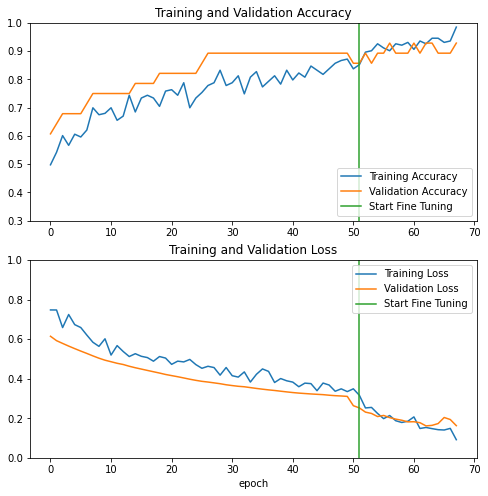

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs+1,initial_epochs+1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs+1,initial_epochs+1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
### Evaluation and prediction

#Finally you can verify the performance of the model on new data using test set.

loss1, accuracy1 = model.evaluate(test_dataset)
print("The test accuracy is {} and loss is {}".format(accuracy1, loss1))

1/1 [==============================] - 1s 930ms/step - loss: 0.2343 - accuracy: 0.8833
The test accuracy is 0.8833333253860474 and loss is 0.23428191244602203


Predictions:
 [0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0
 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1]
Labels:
 [0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0
 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1]


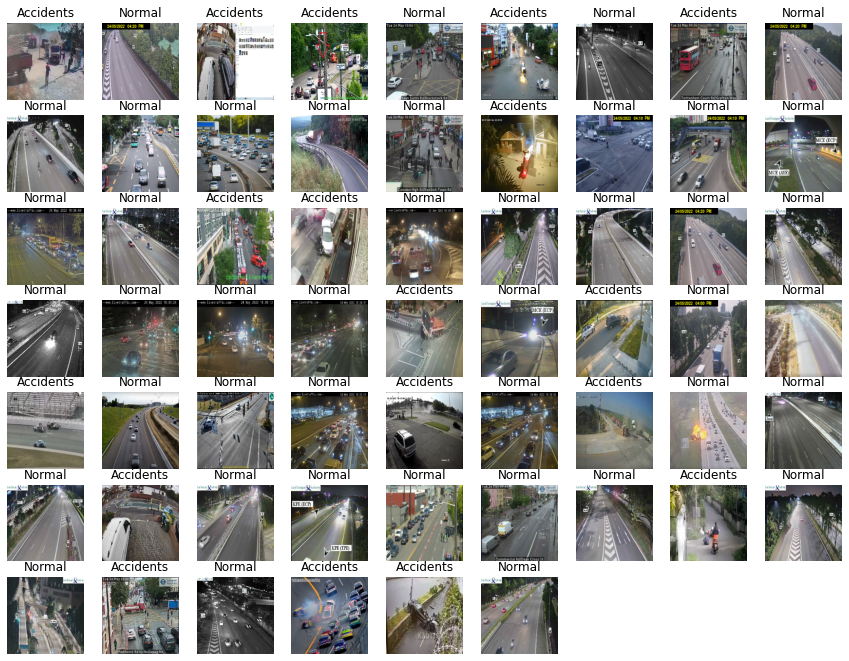

In [27]:
#And now you are all set to use this model to predict if your pet is a normal or accident.

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 15))
for i in range(60):
  ax = plt.subplot(9, 9, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")